### Q3: perform Bayesian Multivariate Classification

- For a data set for which modeling multiple binary outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Use latent `z = pm.MvNormal('z', mu=X@betas, chol=L)` as discussed in the "Generalized Linear Models (GLM)" section of the previous weeks lecture notes

> This provides normally distributed latent variables connected to the observed binary outcomes on which a latent covariance dependency structure may be modelled and estimated on the basis of imputing the unobserved latent variables based on their connection with the observed binary outcome variables.

- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics


In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler

# 1) Load the Pima Indians Diabetes dataset (Kaggle version or UCI version)
#    Make sure "Outcome" is 0/1 indicating diabetes or not.
df = pd.read_csv("diabetes.csv")  # Adjust to your path

# 2) Introduce a SECOND binary outcome
#    Example: "HighBMI" = 1 if BMI >= 30, else 0
df["HighBMI"] = (df["BMI"] >= 30).astype(int)

# 3) Define your outcome columns (m = 2)
outcome_cols = ["Outcome", "HighBMI"]
m = len(outcome_cols)

# 4) Define potential predictors (you can reduce or rearrange as needed)
predictor_cols = [
    "Glucose", 
    "BloodPressure", 
    "Insulin", 
    "Age"
]
p_all = len(predictor_cols)

# 5) Choose different n-levels (downsample/truncate sizes)
#    e.g., small, medium, and full
n_values = [100, 200, 300]

# Optionally vary p as well (e.g., fewer or all predictors)
p_values = [2, p_all]

# We'll store basic diagnostics in a list
results = []

# ------------------------------------------------------------
# 6) Loop over the dataset sizes and number of predictors
# ------------------------------------------------------------
for n_ in n_values:
    # Downsample/truncate the dataset
    # Here we randomly sample n_ rows (you could also do df.head(n_))
    df_subset = df.sample(n=n_, random_state=42)

    for p_ in p_values:
        # Pick the first p_ columns from predictor_cols
        current_predictors = predictor_cols[:p_]
        
        # Extract X (shape = (n_, p_)) and y (shape = (n_, m))
        X_data = df_subset[current_predictors].values
        y_data = df_subset[outcome_cols].values
        
        # (Optional) Standardize predictors for better MCMC sampling
        X_data = StandardScaler().fit_transform(X_data)

        # 7) Build the Bayesian Correlated Probit Model
        with pm.Model() as multivariate_model:
            # (a) Priors for regression coefficients (p_, m)
            betas = pm.Normal("betas", mu=0, sigma=1, shape=(p_, m))
            
            # (b) LKJ Cholesky prior for correlation among latent dimensions
            packed_L = pm.LKJCholeskyCov(
                "packed_L",
                n=m,
                eta=2.0, 
                sd_dist=pm.Exponential.dist(1.0, shape=m),
                compute_corr=False
            )
            L = pm.expand_packed_triangular(m, packed_L)
            
            # (c) Latent variable z: shape = (n_, m)
            mu = pm.math.dot(X_data, betas)
            z = pm.MvNormal("z", mu=mu, chol=L, shape=(n_, m))
            
            # (d) Probit link => p = Φ(z)
            p = pm.math.invprobit(z)
            
            # (e) Bernoulli likelihood for multiple binary outcomes
            y_obs = pm.Bernoulli("y_obs", p=p, observed=y_data)

            # (f) MCMC sampling
            trace = pm.sample()

        # 8) Basic diagnostics: check R-hat, etc.
        summary_ = az.summary(trace, var_names=["betas"])
        max_rhat = summary_["r_hat"].max()
        
        results.append({
            "n": n_,
            "p": p_,
            "m": m,
            "max_rhat": max_rhat
        })
        print(f"\nn={n_}, p={p_}, m={m} -> max R-hat(betas): {max_rhat:.3f}")

# 9) Optional: convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results)
print("\nSummary of runs:")
print(results_df)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, packed_L, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1178 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 692 divergences after tuning. Increase `target_accept` or reparameterize.



n=100, p=2, m=2 -> max R-hat(betas): 1.110


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, packed_L, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1116 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1677 divergences after tuning. Increase `target_accept` or reparameterize.



n=100, p=4, m=2 -> max R-hat(betas): 1.100


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, packed_L, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1129 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1123 divergences after tuning. Increase `target_accept` or reparameterize.



n=200, p=2, m=2 -> max R-hat(betas): 1.270


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, packed_L, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 825 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1281 divergences after tuning. Increase `target_accept` or reparameterize.



n=200, p=4, m=2 -> max R-hat(betas): 1.150


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, packed_L, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3016 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 638 divergences after tuning. Increase `target_accept` or reparameterize.



n=300, p=2, m=2 -> max R-hat(betas): 1.240


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, packed_L, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 781 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1585 divergences after tuning. Increase `target_accept` or reparameterize.



n=300, p=4, m=2 -> max R-hat(betas): 1.420

Summary of runs:
     n  p  m  max_rhat
0  100  2  2      1.11
1  100  4  2      1.10
2  200  2  2      1.27
3  200  4  2      1.15
4  300  2  2      1.24
5  300  4  2      1.42


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",1.050,0.306,0.598,1.624,0.100,0.021,8.0,28.0,1.42
"betas[0, 1]",0.286,0.169,-0.013,0.620,0.017,0.006,103.0,651.0,1.04
"betas[1, 0]",-0.196,0.146,-0.507,0.046,0.016,0.010,106.0,330.0,1.04
"betas[1, 1]",0.179,0.150,-0.108,0.469,0.007,0.011,460.0,665.0,1.08
"betas[2, 0]",-0.061,0.132,-0.321,0.194,0.005,0.012,706.0,497.0,1.08
...,...,...,...,...,...,...,...,...,...
"z[297, 1]",1.531,1.411,-0.749,4.430,0.116,0.078,188.0,430.0,1.05
"z[298, 0]",0.921,1.165,-0.943,3.446,0.159,0.088,66.0,511.0,1.05
"z[298, 1]",0.580,1.364,-1.497,3.370,0.176,0.079,56.0,307.0,1.05
"z[299, 0]",-0.759,1.107,-3.107,0.984,0.158,0.071,58.0,546.0,1.05


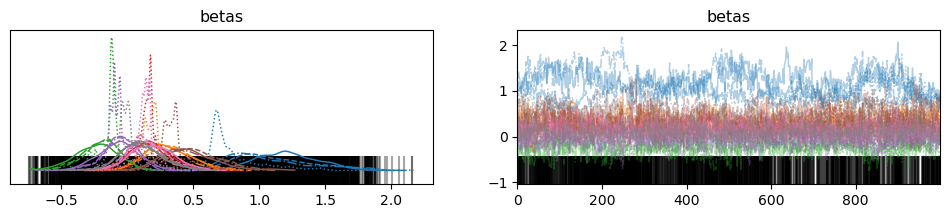

In [2]:
az.plot_trace(trace, var_names=['betas'])   # Trace + distribution plots
az.summary(trace)